## Capstone Project - The Battle of Neighborhoods (Week 1)

*Stuart McGill*

### 1. Introduction

#### 1.1 Business Problem: Searching for a New home in a New City

According to the [US Census Bureau](https://www.census.gov/data/tables/time-series/demo/geographic-mobility/historic.html), every year approximately 32 Million Americans move home. Moving to a new city is a difficult undertaking and can result in a lot of stress. Especially when you like the facilities and venues in your current accommodation. There may be many different locations in a vast number of neighbourhoods to choose from. 

Albert Einstein famously worked on three rules, [“Out of clutter, find simplicity. From discord, find harmony. In the middle of difficulty, lies opportunity.”](http://www.bigear.org/vol1no4/wheeler.htm). The difficulty faced by the huge number of people moving home annually and real-estate and rental industries make up the target audience of stakeholders who face this problem. Simplifying the search for new accommodation in a new city has real value for people moving home by reducing the cognitive load and accompanying stress. Having a way to contextualise real-estate / rental listings based on a users current location would give a real-estate company a competitive advantage. These reasons explain why people moving to a new city and real-estate / rental-listing companies care about simplifying the problem of search for a new home in an new city.

#### 1.2 Solution: Contextualize the Unfamiliar City

To make moving home easier, you need a reference point, where potential neighborhoods in the new city are compared to your current location. Imagine a real-estate / rental-listing website (such as [zillow](https://www.zillow.com/) or [realtor](https://www.realtor.com/) being able to contextualise the potential neighborhoods based on their similarity of surrounding facilities to your current accommodation. To do this, the user's current city's neighbourhoods would be clustered. These clusters would then be used as class labels, for training a classification algorithm. This classifier would then assign neighborhoods in the new city to be like neighbourhood clusters in the current city. This would provide the user with a common reference point to filter their options, reducing the cognitive demand of selecting a new home.

As a proof of concept case study, Los Angeles (USA) is selected as the current city and New York City (USA) is selected as the moving location. Then a three-step process is applied with the aim to make unfamiliar New York understandable by relating the neighborhoods to Los Angeles:

 1. The neighborhoods of Los Angeles will be clustered based on their surrounding facilities.
 2. These clusters will be used as labels to train a classifier.
 3. The classifier will then be applied to New York City neighborhoods, providing context for the new city via analogy to the current residence.


### 2. Data

#### 2.1 Sources

Neighborhood names and boundaries, as defined by the latitude, longitude coordinates of bounding polygons of the will be sourced from [Neighborhood Data for Social Change](https://usc.data.socrata.com/dataset/Los-Angeles-Neighborhood-Map/r8qd-yxsr) for Los Angeles and [New York Open Data](https://data.cityofnewyork.us/City-Government/Neighborhood-Tabulation-Areas-NTA-/cpf4-rkhq) for New York City. To simplify what venues are considered to be within a neighbourhood, the [centroid of the bounding polygon](https://en.wikipedia.org/wiki/Centroid#Of_a_polygon) will be calculated. Venues will be considered as part of the neighbourhood if they fall within 1000 metre radius of the centroid of each neighborhood polygon (see data exploration for update).

The types of venues (categories) of the surrounding businesses and facilities in each neighbourhood will be sourced from the [Foursquare Places API](https://developer.foursquare.com/docs/api). The venue categories might not be distinct, for example cafes, coffee houses, and coffee bars should probably be considered the same type of venue. So the venue categories will be clustered based on their semantic meaning using a natural-language-processing word-embedding distance metric. 

Each category cluster will form a feature dimension for clustering and classification. For each neighborhood, the number of venues in each category cluster will be counted. Then each category cluster count will be divided by the total neighborhood venues. So, the features of each neighborhood are the venue category clusters as a proportion of the total venues within the neighborhood. 

The neighborhood proportion-venue vector, that sums to one, can be considered to fall with in a [simplex](https://en.wikipedia.org/wiki/Simplex). A simplex can be considered to be a generalization of the idea of a triangle to any number of dimensions. The neighborhood features fall within the space defined by the simplex. This complicates comparing neighborhoods because their feature vectors are not well described by Euclidean metrics as their space is non-Euclidean. Therefore, the [Hilbert simplex distance](https://arxiv.org/pdf/1704.00454.pdf) will be used as an appropriate distance metric for this data.



#### 2.2 Getting the data




In [70]:
# Importing modules
import requests
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import folium
import seaborn as sns
import shapely
import geojson


In [71]:
# requesting location data for each city 
la_neighborhood_url = 'https://usc.data.socrata.com/resource/9utn-waje.json'
ny_neighborhood_url = 'https://data.cityofnewyork.us/resource/q2z5-ai38.json'

#la_req = requests.get(la_neighborhood_url)
#ny_req = requests.get(ny_neighborhood_url)

#ny data is not open anymore


with open('./Los Angeles Neighborhood Map.geojson', 'r') as f:
    la_json = geojson.loads(f.read())

with open('./New York City Neighborhood Map.geojson', 'r') as f:
    ny_json = geojson.loads(f.read())

In [ ]:
# plot LA neighborhoods with folium

la_lat_lng = (34.15223, -118.24368)
ny_lat_lng = (40.71427, -74.00597)

la_maploc = folium.Map(location=la_lat_lng,zoom_start=9,tiles="Stamen Toner")

folium.GeoJson(la_json, style_function = lambda x: {'weight' : 1}).add_to(la_maploc)


ny_maploc = folium.Map(location=ny_lat_lng,zoom_start=11,tiles="Stamen Toner")

folium.GeoJson(ny_json, style_function = lambda x: {'weight' : 1}).add_to(ny_maploc)


import time
time.sleep(5)
ny_maploc.save('ny_map_df.html')
la_maploc.save('la_map_df.html')

In [ ]:
#display LA neighborhood map
from IPython.display import IFrame

IFrame(src='./la_map_df.html',width=1000, height=800)

In [ ]:
#display NY map neighborhoods
from IPython.display import IFrame

IFrame(src='./ny_map_df.html',width=1000, height=900)

In [356]:
from shapely.geometry import shape

def to_radians(val):
    return (val * np.pi) / 180.
        
def get_poly_area(coordinates, earth_radius=6378137):
    area = 0
    if (len(coordinates) > 2):
        for i in range(len(coordinates)-1):
            p1 = coordinates[i];
            p2 = coordinates[i + 1];
            area += to_radians(p2[0] - p1[0]) * (2 + np.sin(to_radians(p1[1])) + np.sin(to_radians(p2[1])));
        area = area * earth_radius **2 / 2.;
    return abs(area)

def get_shape_area(s):
    area = 0
    if s.geom_type == 'Polygon':
        area = get_poly_area( s.exterior.coords) 
        for interior in s.interiors:
            area -= get_poly_area( interior.coords)
    else:
        for p in s:
            area += get_poly_area(p.exterior.coords)
            for interior in p.interiors:
                area -= get_poly_area( interior.coords)
    return area

def get_areas(city_json):
    
    #polygons = [ Polygon(d['geometry']['coordinates'][0])  if d['geometry']['type'] == 'Polygon' else Polygon(d['geometry']['coordinates'][0][0]) for d in city_json['features']]
    shapes = [ shape(d['geometry']) for d in city_json['features'] ]
    
    poly_area = [ get_shape_area(s) for s in shapes]
    return poly_area

def get_centroids(city_json):
    centroids = [list( shape(d['geometry']).centroid.coords)[0] for d in city_json['features']]

    return centroids
    


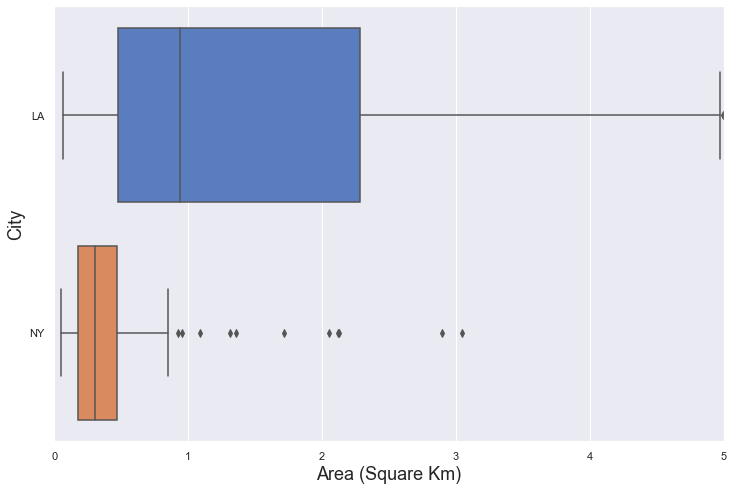

In [358]:
#make data frame with neighborhood names, centroids, areas
#get centroids
la_centroids = get_centroids(la_json)
ny_centroids = get_centroids(ny_json)

all_longitudes = [p[0] for p in la_centroids] + [p[0] for p in ny_centroids] 
all_latitudes = [p[1] for p in la_centroids] + [p[1] for p in ny_centroids] 

la_poly = get_areas(la_json)
ny_poly = get_areas(ny_json)

all_area = la_poly + ny_poly


ny_names = [ d['properties']['NTAName'] for d in ny_json['features']]

la_names = [ d['properties']['name'] for d in la_json['features']]


all_names =  la_names + ny_names 
cities = ['LA'] *len(la_poly) + ['NY']*len(ny_poly)

df = pd.DataFrame({'Name' : all_names, 'City_name': cities,  'Area' :all_area, 'Longitude': all_longitudes, 'Latitude': all_latitudes })
df['Area'] = df['Area']/1e7

sns.set()
fig = plt.figure(figsize= (12,8))

ax = sns.boxplot(x="Area", y="City_name",
                    data=df, palette="muted")
ax.set_ylabel('City',fontsize=18)
ax.set_xlabel('Area (Square Km)',fontsize=18)
ax.set_xlim(0,5)

fig.savefig('./City_neighborhood_area_box.png', dpi=300)

In [ ]:
df.head()

The maps demonstrate that the neighborhoods in each city are quite different. Los Angeles has much larger neighborhood areas compared to New York City, and has a quite a few very large neighborhoods. This is an important factor to consider when gathering the neighborhood facilities. Originally, it was planned to use a venue inclusion radius of 1000 metres for both cities. However,Given the difference in areas, the venue inclusion radius for Los Angeles is set to 1250 metres, whereas the inclusion radius for New York City is set to 500 metres. 

In [ ]:


for i,coord in enumerate(la_centroids):
    if la_poly[i]/1e7 > 5:
        folium.CircleMarker([coord[1], coord[0]], popup=la_names[i],radius=2,color='red').add_to(la_maploc)
        folium.GeoJson(la_json['features'][i], style_function = lambda x: {'weight' : 1, 'fillColor':'red'}).add_to(la_maploc)
    else:
        folium.CircleMarker([coord[1], coord[0]], popup=la_names[i],radius=2,color='blue').add_to(la_maploc)
time.sleep(5)
la_maploc.save('la_map_markers_js.html')

Given the neighborhood radius definitions, outlier Los Angeles neighborhoods were excluded from further analysis. The map below shows the excluded neighborhoods highlighted in red.

In [359]:
IFrame(src='./la_map_markers_js.html',width=1000, height=800)

In [ ]:
for i,coord in enumerate(ny_centroids):
    folium.CircleMarker([coord[1], coord[0]], popup=ny_names[i],radius=2).add_to(ny_maploc)
time.sleep(5)
ny_maploc.save('ny_map_markers_js.html')

In [244]:
IFrame(src='./ny_map_markers_js.html',width=1000, height=800)

In [ ]:
CLIENT_ID = '' # your Foursquare ID
CLIENT_SECRET = '' # your Foursquare Secret
VERSION = '20180605'


In [ ]:
# function to get Foursquare data

def get_nearby_venues(df, radius=500, limit=100):
  
    venues_list=[]

        
    for i, row in df.iterrows():
        name, city, lat, lng = row[['Name', 'City_name', 'Latitude', 'Longitude']]
        if row['City_name'] == 'LA':
            radius = 1250
        else:
            radius = 500
        print(name, city, lat, lng, radius)
            
        # create the API request URL
        url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION, 
            lat, 
            lng, 
            radius, 
            limit)
        
        # make the GET request
        is_continue = True
        while is_continue:
            time.sleep(1)
            try:
                results_json = requests.get(url).json()

                results = results_json["response"]['groups'][0]['items']
                is_continue = False
                
            except Exception as e:
                print(e)
                print(results_json)
                
            
        
        # return only relevant information for each nearby venue
        venues_list.append([(
            name, 
            city,
            lat, 
            lng, 
            v['venue']['name'], 
            v['venue']['location']['lat'], 
            v['venue']['location']['lng'],  
            v['venue']['categories'][0]['name']) for v in results])


    nearby_venues = pd.DataFrame([item for venue_list in venues_list for item in venue_list])
    nearby_venues.columns = ['Neighborhood', 
                             'City Name',
                  'Neighborhood Latitude', 
                  'Neighborhood Longitude', 
                  'Venue', 
                  'Venue Latitude', 
                  'Venue Longitude', 
                  'Venue Category']
    
    
    return(nearby_venues)


In [ ]:
nearby_venues = get_nearby_venues( df[ df['Area'] <= 5])

In [ ]:

nearby_venues.groupby('Neighborhood').count()

In [ ]:
nearby_venues.to_csv('./City_neighborhood_venues.csv', index=False)
nearby_venues




### 3. Methodology 

#### 3.1 Feature Exploration and Engineering: Clustering Venue Categories via Natural Language Processing

The venue categories for all the surrounding venues, at each neighborhood in Los Angeles and New York City form the features for the clustering and classification. However, there is no guarentee that the categories are mutually exclusive. So exploration of their sematic similarity is needed to assess whether some categories need to be combined.

This presents its own challenge as there are over 400 categories to compare. In order to make this comparison more managable, venue categories were converted into 100 dimensional vectors using the *word2vec* embedding trained on wikipedia data (available [here](http://wikipedia2vec.s3.amazonaws.com/models/en/2018-04-20/enwiki_20180420_100d.txt.bz2)).

The venue categories were converted by first splitting them into lists of single words, then each word was converted to the vector. The vectors were summed together then divided by the total number of words in the category. This produced one 100 dimesion vector per category (venue vector). 

The venue vectors distance matrix was calculated using the cosine distance metric. Subsequently the vectors were clustered with Agglomerative Heirarchical Clustering and visualised with a dendrogram. The threshold of .1 was chosed, by visual inspection, below which all venues were manually inspected for semantic overlap. 55 categories were found to have some degree of overlap and were combined into 24 categories.


After combination there were 464 venue categories. These were one-hot-encoded and summed together for each neighborhood. This formed a multinomial vector representing each neighborhood. These neighborhood vectors were converted into simplexes (vectors whos elements sum to one) using Dirichlet flat prior (adding one to each element then dividing by the vector by the sum of each row). This meant that each simplex represented an estimate of the proportion of venue categories surrounding each neighborhood.





In [3]:
#3.1 Feature Engineering: Clustering Venue Categories via Natural Language Processing
from gensim.models import KeyedVectors

from nltk import WordPunctTokenizer
import nltk
import numpy as np 
import pandas as pd

from sklearn import metrics
from sklearn.cluster import AgglomerativeClustering
from scipy.cluster.hierarchy import dendrogram

from scipy.spatial.distance import cosine
import matplotlib.pyplot as plt

In [2]:
model = KeyedVectors.load_word2vec_format('./enwiki_20180420_100d.txt/enwiki_20180420_100d.txt', binary=False)

In [27]:
nearby_venues = pd.read_csv('./City_neighborhood_venues.csv')

In [4]:
def tokenise_categories(cat):
    tokens = tuple([ s.lower().replace('-','') for s in cat.split() if s != '/'])
    return tokens

venue_tokens = nearby_venues['Venue Category'].apply(tokenise_categories)

venue_cat = list(set(venue_tokens))
token_mapper = {key:value for key,value in zip(venue_tokens, nearby_venues['Venue Category'])}

In [5]:

def sent_vectorizer(sent, model):
    sent_vec =[]
    numw = 0
    for w in sent:
        try:
            if numw == 0:
                sent_vec = model[w]
            else:
                sent_vec = np.add(sent_vec, model[w])
            numw+=1
        except:
            pass
     
    return np.asarray(sent_vec) / numw
  

X=[]
for sentence in venue_cat:
    X.append(sent_vectorizer(sentence, model))   


In [6]:
word_embeddings = pd.DataFrame(X, columns=['d_' + str(i) for i in range(100)])
word_embeddings.index = nearby_venues['Venue Category'].unique()
word_embeddings.head()
word_embeddings.to_csv('./word_embeddings.csv')

In [363]:
word_embeddings = pd.read_csv('./word_embeddings.csv').drop(columns='Unnamed: 0')
X = word_embeddings.values

In [364]:

distance_mat = np.zeros( (len(X), len(X)))
for i, vec_x in enumerate(X):
    for j, vec_y in enumerate(X):
        distance_mat[i,j] = cosine(vec_x, vec_y)
        
    

In [13]:

def plot_dendrogram(model, **kwargs):
    # Create linkage matrix and then plot the dendrogram

    # create the counts of samples under each node
    counts = np.zeros(model.children_.shape[0])
    n_samples = len(model.labels_)
    for i, merge in enumerate(model.children_):
        current_count = 0
        for child_idx in merge:
            if child_idx < n_samples:
                current_count += 1  # leaf node
            else:
                current_count += counts[child_idx - n_samples]
        counts[i] = current_count

    linkage_matrix = np.column_stack([model.children_, model.distances_,
                                      counts]).astype(float)
    
    dendrogram(linkage_matrix, **kwargs)

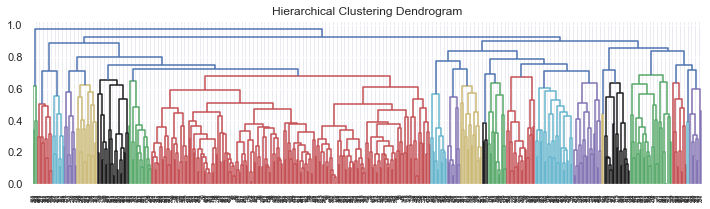

In [366]:
cluster_words = AgglomerativeClustering(affinity='precomputed', distance_threshold=0.0, linkage='complete', n_clusters=None)

cluster_words = cluster_words.fit(distance_mat)
fig = plt.figure(figsize=(12,3))
plt.title('Hierarchical Clustering Dendrogram')

plot_dendrogram(cluster_words)

fig.savefig('./venue_name_dendrogram.png',dpi=300)


In [10]:
potential_overlaps = [(venue_cat[x],venue_cat[y], x,y) for (x,y) in zip(np.nonzero(distance_mat < .1)[0],np.nonzero(distance_mat < 0.1)[1]) if x != y]

In [11]:
confirmed_overlap = []
checked_pairs = []
for pair in potential_overlaps:
    if pair in checked_pairs:
        continue
    print(pair)
    checked_pairs.append( (pair[1],pair[0]) )
    user_resp = input('Is this overlapped?')
    if user_resp == 'q':
        break
    is_overlap = user_resp in ['y', 'yes']
    if is_overlap:
        confirmed_overlap.append(pair)


(('falafel', 'restaurant'), ('kebab', 'restaurant'), 0, 96)
Is this overlapped?n
(('south', 'indian', 'restaurant'), ('south', 'american', 'restaurant'), 2, 86)
Is this overlapped?n
(('south', 'indian', 'restaurant'), ('indian', 'restaurant'), 2, 176)
Is this overlapped?y
(('south', 'indian', 'restaurant'), ('north', 'indian', 'restaurant'), 2, 469)
Is this overlapped?y
(('jewelry', 'store'), ('clothing', 'store'), 8, 342)
Is this overlapped?n
(('jewelry', 'store'), ('shoe', 'store'), 8, 441)
Is this overlapped?n
(('college', 'classroom'), ('college', 'cafeteria'), 11, 450)
Is this overlapped?y
(('high', 'school'), ('school',), 16, 379)
Is this overlapped?y
(('soccer', 'stadium'), ('baseball', 'stadium'), 17, 339)
Is this overlapped?n
(('soccer', 'stadium'), ('football', 'stadium'), 17, 435)
Is this overlapped?y
(('museum',), ('history', 'museum'), 18, 190)
Is this overlapped?y
(('museum',), ('art', 'museum'), 18, 245)
Is this overlapped?y
(('dessert', 'shop'), ('pastry', 'shop'), 19, 

(('vietnamese', 'restaurant'), ('cambodian', 'restaurant'), 285, 122)
Is this overlapped?n
(('vietnamese', 'restaurant'), ('chinese', 'restaurant'), 285, 144)
Is this overlapped?n
(('taco', 'place'), ('pizza', 'place'), 287, 354)
Is this overlapped?n
(('warehouse', 'store'), ("men's", 'store'), 290, 75)
Is this overlapped?n
(('warehouse', 'store'), ("women's", 'store'), 290, 115)
Is this overlapped?n
(('warehouse', 'store'), ('grocery', 'store'), 290, 307)
Is this overlapped?n
(('comfort', 'food', 'restaurant'), ('fast', 'food', 'restaurant'), 292, 341)
Is this overlapped?n
(('bike', 'trail'), ('trail',), 300, 230)
Is this overlapped?y
(('modern', 'european', 'restaurant'), ('eastern', 'european', 'restaurant'), 301, 246)
Is this overlapped?n
(('grocery', 'store'), ('liquor', 'store'), 307, 21)
Is this overlapped?n
(('grocery', 'store'), ("men's", 'store'), 307, 75)
Is this overlapped?n
(('grocery', 'store'), ("women's", 'store'), 307, 115)
Is this overlapped?n
(('grocery', 'store'), (

In [12]:
no_doubles_overlap = []
seen = []
for row in confirmed_overlap:
    check = (row[2]*1000 + row[3]) if row[2] < row[3] else (row[3]*1000 + row[2])
    if not( check in seen):
        no_doubles_overlap.append(row)
        seen.append(check)

In [13]:

def get_venue_cat_tuples(token_mapper, tuples):
    col_names =[]
    for keys in tuples:
        col_names.append([token_mapper[key] for key in keys])
    return col_names


def combine_pairs_simple(no_doubles_overlap):
    #get unique column values
    unique_set = set()
    for row in no_doubles_overlap:
        unique_set.add(row[0])
        unique_set.add(row[1])
    
    #make adjacency dictionary
    d1 = {key:[] for key in unique_set}
    
    for row in no_doubles_overlap:
        d1[row[0]].append(row[1])
        d1[row[1]].append(row[0])
    
    #make lists of columns to be combined
    sets = []
    seen_set = set()
    for key in d1.keys():
        new_set = set()
        new_set.add(key)
        next_keys = d1[key]
        
        while len(next_keys) >0:
            next_key = next_keys.pop()
            if next_key not in new_set:
                new_set.add(next_key)
                next_keys.extend( d1[next_key])
        is_new = True
        for i,s in enumerate(sets):
            if not s.isdisjoint(new_set):
                is_new = False
                sets[i] = s.union(new_set)
                break
        if is_new:
            sets.append(new_set)
    return [ list(s) for s in sets]
        
  

In [15]:
tuples_overlap = combine_pairs_simple(no_doubles_overlap)

cols_to_combine = get_venue_cat_tuples(token_mapper,tuples_overlap)

for cols in cols_to_combine:
    print(cols)

['Airport', 'Airport Terminal']
['School', 'High School']
['Cantonese Restaurant', 'Taiwanese Restaurant', 'Chinese Restaurant']
['North Indian Restaurant', 'South Indian Restaurant', 'Indian Restaurant']
['Restaurant', 'Bistro']
['Dessert Shop', 'Pastry Shop']
['Botanical Garden', 'Garden']
['Video Game Store', 'Video Store']
['New American Restaurant', 'American Restaurant']
['Museum', 'Art Gallery', 'Art Museum', 'History Museum']
['Gym', 'Gym Pool']
['Plaza', 'Shopping Plaza', 'Shopping Mall']
['Donut Shop', 'Cupcake Shop']
['Wine Bar', 'Whisky Bar', 'Beer Bar']
['Indie Theater', 'Indie Movie Theater', 'Movie Theater']
['College Classroom', 'College Cafeteria']
['Zoo', 'Zoo Exhibit']
['Japanese Restaurant', 'Japanese Curry Restaurant']
['Trail', 'Bike Trail']
['Theme Park', 'Theme Park Ride / Attraction']
['Train Station', 'Train']
['Bus Line', 'Bus Station']
['Beer Store', 'Liquor Store']
['Football Stadium', 'Soccer Stadium']


In [30]:
cols_to_combine = [['Airport', 'Airport Terminal'],
['School', 'High School'],
['Cantonese Restaurant', 'Taiwanese Restaurant', 'Chinese Restaurant'],
['North Indian Restaurant', 'South Indian Restaurant', 'Indian Restaurant'],
['Restaurant', 'Bistro'],
['Dessert Shop', 'Pastry Shop'],
['Botanical Garden', 'Garden'],
['Video Game Store', 'Video Store'],
['New American Restaurant', 'American Restaurant'],
['Museum', 'Art Gallery', 'Art Museum', 'History Museum'],
['Gym', 'Gym Pool'],
['Plaza', 'Shopping Plaza', 'Shopping Mall'],
['Donut Shop', 'Cupcake Shop'],
['Wine Bar', 'Whisky Bar', 'Beer Bar'],
['Indie Theater', 'Indie Movie Theater', 'Movie Theater'],
['College Classroom', 'College Cafeteria'],
['Zoo', 'Zoo Exhibit'],
['Japanese Restaurant', 'Japanese Curry Restaurant'],
['Trail', 'Bike Trail'],
['Theme Park', 'Theme Park Ride / Attraction'],
['Train Station', 'Train'],
['Bus Line', 'Bus Station'],
['Beer Store', 'Liquor Store'],
['Football Stadium', 'Soccer Stadium']]

In [31]:
sum([len(cols) for cols in cols_to_combine]), len(cols_to_combine)

(55, 24)

In [32]:
one_hot_venues = pd.get_dummies(nearby_venues['Venue Category'], prefix= '', prefix_sep = '')
one_hot_venues['Neighborhood'] = nearby_venues['Neighborhood']

# mapper = { name: real_name in for name, real_name in zip( ny_names +la_names ,  la_names + ny_names)}
# nearby_venues.replace(mapper,inplace=True)
one_hot_venues['City Name'] =nearby_venues['City Name']

one_hot_venues = one_hot_venues[ ['Neighborhood', 'City Name'] + [s for s in one_hot_venues.columns if s not in [ 'Neighborhood', 'City Name']]]
for cols in cols_to_combine:
    new_name = ','.join(cols)
    print(new_name ,one_hot_venues[cols].sum(axis=1).shape)
    one_hot_venues[new_name] = one_hot_venues[cols].sum(axis=1)
    one_hot_venues.drop(columns=cols,inplace=True)


Airport,Airport Terminal (18364,)
School,High School (18364,)
Cantonese Restaurant,Taiwanese Restaurant,Chinese Restaurant (18364,)
North Indian Restaurant,South Indian Restaurant,Indian Restaurant (18364,)
Restaurant,Bistro (18364,)
Dessert Shop,Pastry Shop (18364,)
Botanical Garden,Garden (18364,)
Video Game Store,Video Store (18364,)
New American Restaurant,American Restaurant (18364,)
Museum,Art Gallery,Art Museum,History Museum (18364,)
Gym,Gym Pool (18364,)
Plaza,Shopping Plaza,Shopping Mall (18364,)
Donut Shop,Cupcake Shop (18364,)
Wine Bar,Whisky Bar,Beer Bar (18364,)
Indie Theater,Indie Movie Theater,Movie Theater (18364,)
College Classroom,College Cafeteria (18364,)
Zoo,Zoo Exhibit (18364,)
Japanese Restaurant,Japanese Curry Restaurant (18364,)
Trail,Bike Trail (18364,)
Theme Park,Theme Park Ride / Attraction (18364,)
Train Station,Train (18364,)
Bus Line,Bus Station (18364,)
Beer Store,Liquor Store (18364,)
Football Stadium,Soccer Stadium (18364,)


In [33]:
one_hot_venues.shape

(18364, 464)

In [54]:
# group by neighborhood and sum

neighborhood_venues  = one_hot_venues.groupby('Neighborhood').sum() + 1.
# sum rows to total
totals = neighborhood_venues.sum(axis=1)

# divide elements in each row by total
neighborhood_simplex = pd.DataFrame()
for col in neighborhood_venues.columns:
    temp =  neighborhood_venues[col]  /totals
    neighborhood_simplex[col] =temp



print(np.all(np.isclose(neighborhood_simplex.sum(axis=1) , 1)))
neighborhood_simplex.reset_index(inplace=True)
neighborhood_simplex = pd.merge(neighborhood_simplex ,nearby_venues[['Neighborhood','City Name']].drop_duplicates(), how='inner', left_on='Neighborhood',right_on='Neighborhood')
# save simplex data
print(neighborhood_simplex)
neighborhood_simplex.to_csv('./neighborhood_simplex.csv')

True
                        Neighborhood       ATM  Accessories Store  \
0                    Adams-Normandie  0.003906           0.001953   
1                       Agoura Hills  0.003731           0.001866   
2                            Airport  0.002088           0.002088   
3                           Alhambra  0.001866           0.001866   
4            Allerton-Pelham Gardens  0.002070           0.002070   
..                               ...       ...                ...   
438          park-cemetery-etc-Bronx  0.002062           0.002062   
439       park-cemetery-etc-Brooklyn  0.002012           0.002012   
440      park-cemetery-etc-Manhattan  0.002004           0.002004   
441         park-cemetery-etc-Queens  0.002119           0.002119   
442  park-cemetery-etc-Staten Island  0.002141           0.002141   

     Acupuncturist  Adult Boutique  Advertising Agency  Afghan Restaurant  \
0         0.001953        0.001953            0.001953           0.001953   
1         0.

In [257]:
neighborhood_simplex['City Name']


0      LA
1      LA
2      NY
3      LA
4      NY
       ..
438    NY
439    NY
440    NY
441    NY
442    NY
Name: City Name, Length: 443, dtype: object

#### 3.2 Unsupervised Learning and Exploration: Clustering Los Angeles Neighborhoods

The Los Angeles neighborhood simplexes had a distance matrix calculated using [hilbert simplex distance](https://arxiv.org/pdf/1704.00454.pdf), which is a metric designed for estimating distances within non-Euclidean simplex spaces. Then the distance matrix was used to cluster the neighborhoods with Agglomertative Heirarchical Clustering (full linkage) and was visualised with a dendrogram.

Two neighborhoods, *Universal City* and *San Marino* were identified as outliers, as they would form their own clusters. Subsequent investigation excluded these neighborhoods.

Subsequently Silhouette Plots with 2-dimensional embeddings (using Multi-Dimensional Scaling) were used to explore the quality of the clustering, and average silhouette scores were also used as a clustering metric.



In [60]:
# get LA neighborhood simplexes
from HilbertSimplexDistance.Multinomial import Multinomial

#neighborhood_simplex = pd.read_csv('./neighborhood_simplex.csv').drop(columns=['Unnamed: 0'])

LA_simplex = neighborhood_simplex[ neighborhood_simplex['City Name'] == 'LA']
LA_simplex = LA_simplex[ ~ LA_simplex['Neighborhood'].isin(['Universal City','San Marino' ])]
LA_simplex = LA_simplex.drop(columns=['City Name', 'Neighborhood']) 
# calculate hilbert simplex distance matrix


def get_distance_mat(simplex):
    multi_noms = [ Multinomial(p=p.tolist()) for i,p in enumerate(simplex)]
    LA_X = np.zeros( (len(multi_noms), len(multi_noms)) )
    for i in range( len(multi_noms)):

        for j in range( len(multi_noms)):
            LA_X[i,j] = multi_noms[i].hilbert_distance( multi_noms[j])

    return LA_X

LA_X = get_distance_mat(LA_simplex.values)


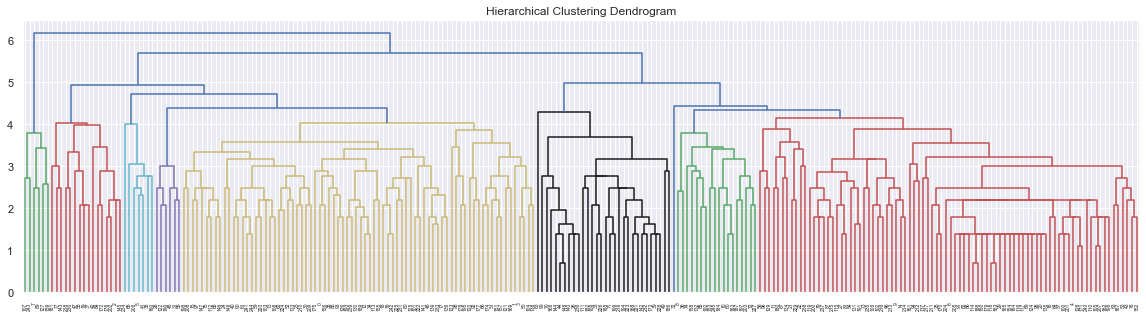

In [367]:
# agglomerative clustering, plot dendrogram

cluster_la = AgglomerativeClustering(affinity='precomputed', distance_threshold=0, linkage='complete', n_clusters=None)

cluster_la = cluster_la.fit(LA_X)

fig = plt.figure(figsize=(20,5))
plt.title('Hierarchical Clustering Dendrogram')

plot_dendrogram(cluster_la)

plt.show()

fig.savefig('./la_clustering_dendrogram.png', dpi=300)

For n_clusters = 2 The average silhouette_score is : 0.278752362781884
For n_clusters = 3 The average silhouette_score is : 0.07404784388170313
For n_clusters = 4 The average silhouette_score is : 0.0237212286973931
For n_clusters = 5 The average silhouette_score is : 0.03158079258374293
For n_clusters = 6 The average silhouette_score is : 0.03776156299520656
For n_clusters = 7 The average silhouette_score is : 0.03750396229537525
For n_clusters = 8 The average silhouette_score is : 0.03355836032032115
For n_clusters = 9 The average silhouette_score is : 0.03368693736308751
For n_clusters = 10 The average silhouette_score is : 0.03066464193093271


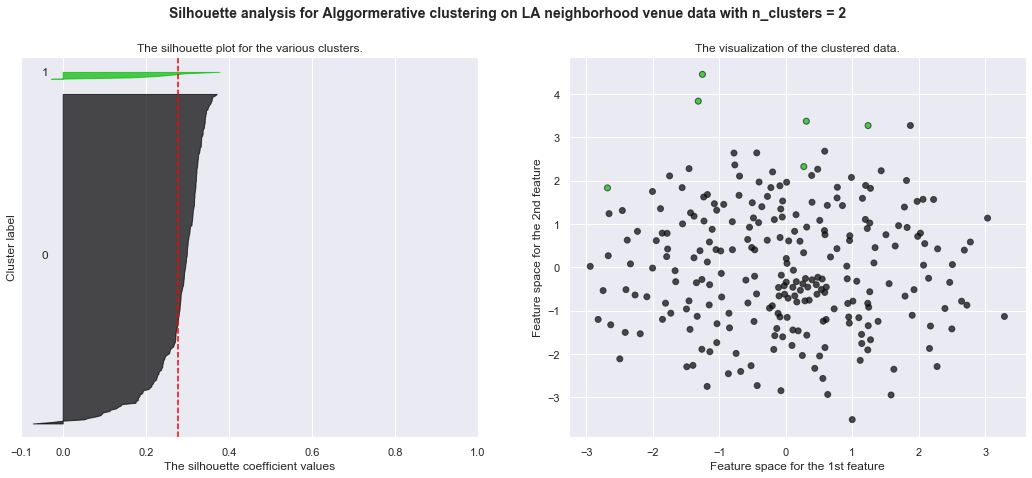

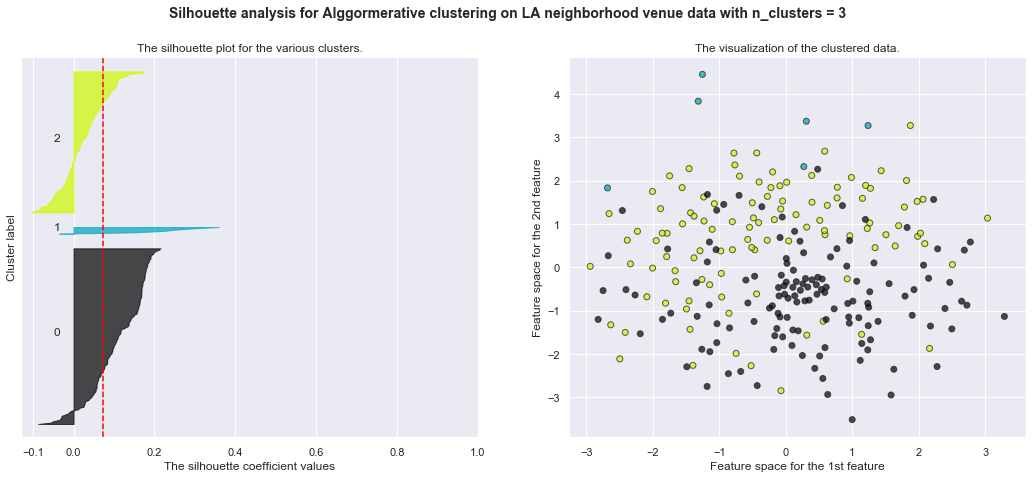

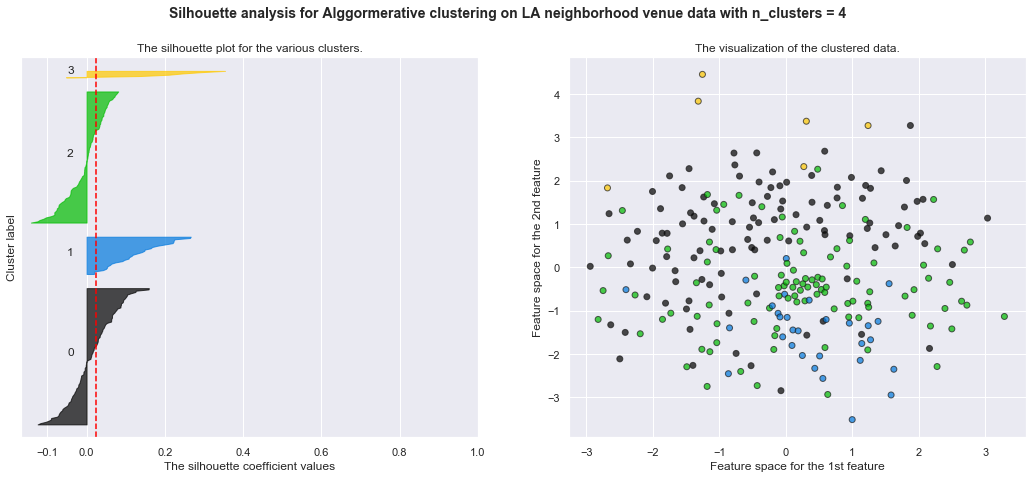

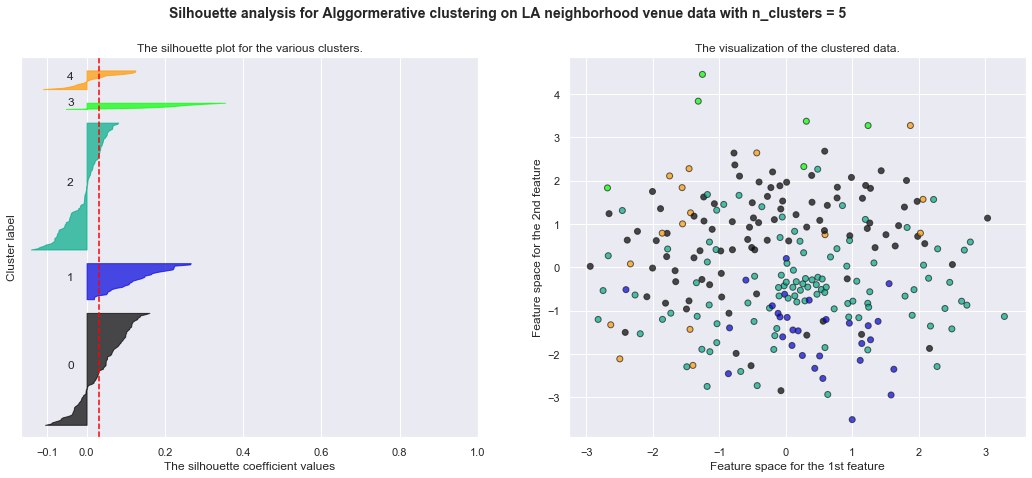

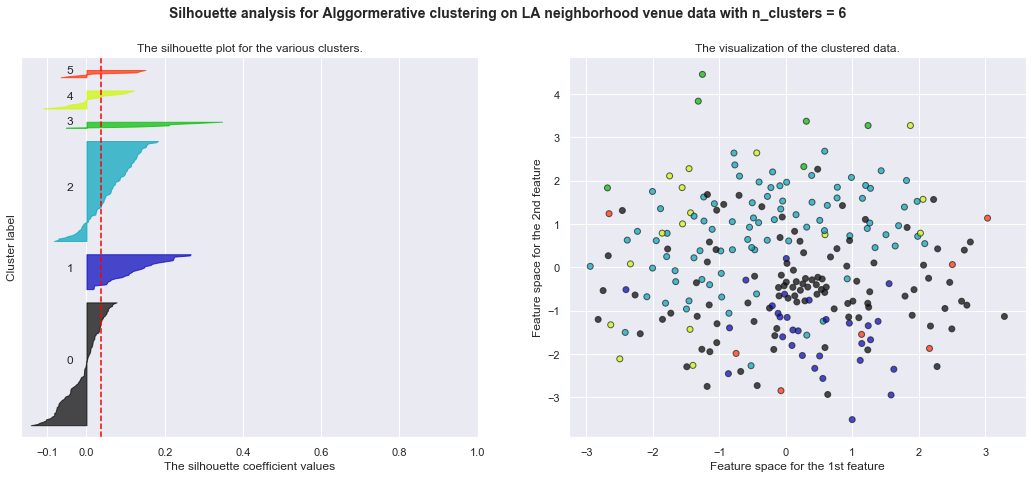

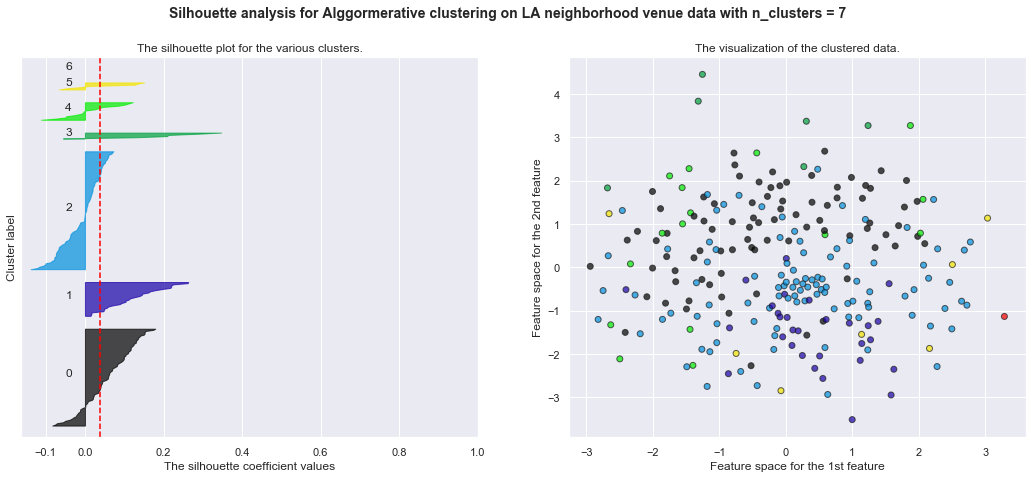

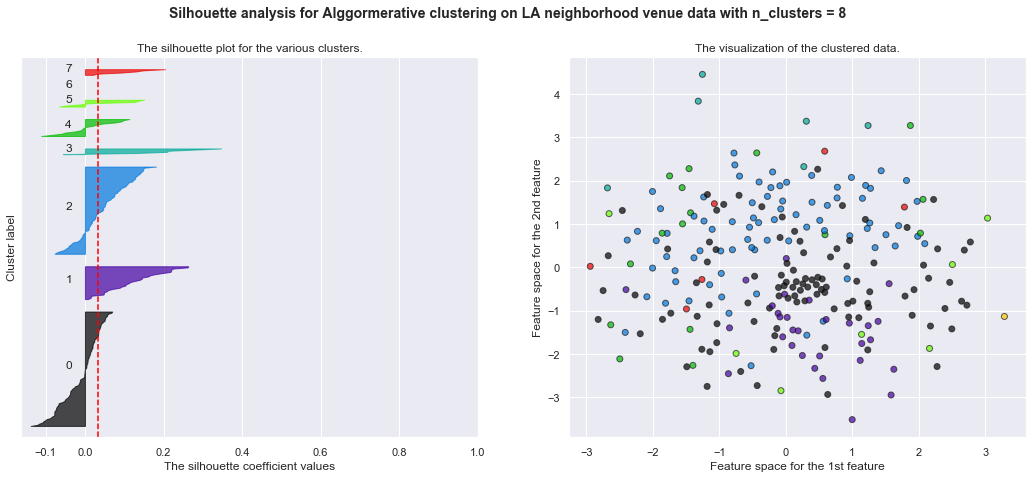

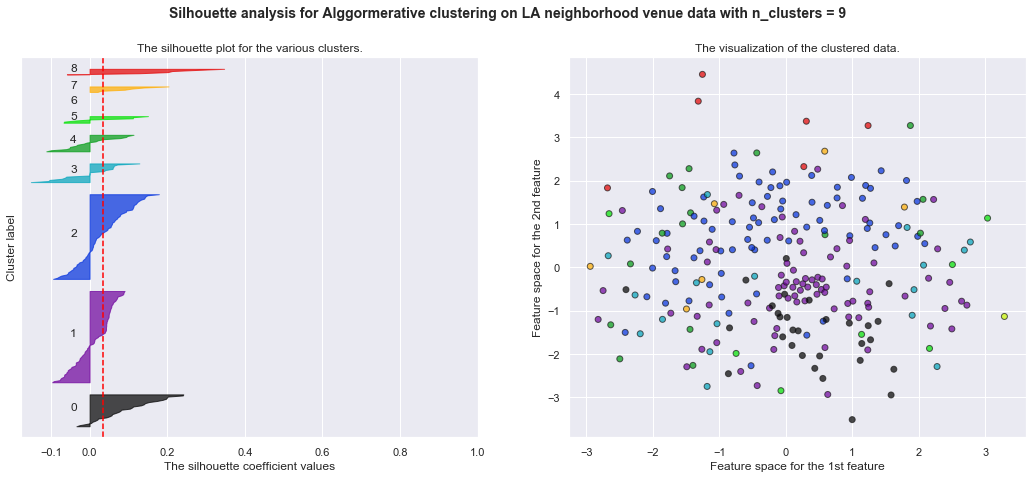

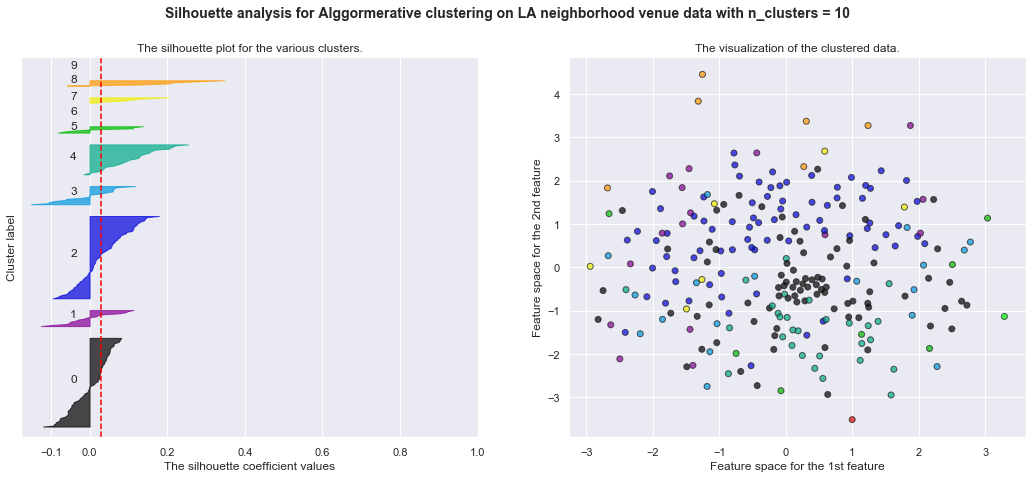

In [370]:
from sklearn.metrics import silhouette_samples, silhouette_score
import matplotlib.cm as cm

range_n_clusters = list(range(2,11))

mds = manifold.MDS(n_components=2, dissimilarity='precomputed', max_iter=100, n_init=1, )
Y = mds.fit_transform(LA_X)

for n_clusters in range_n_clusters:
    # Create a subplot with 1 row and 2 columns
    fig, (ax1, ax2) = plt.subplots(1, 2)
    fig.set_size_inches(18, 7)

    # The 1st subplot is the silhouette plot
    # The silhouette coefficient can range from -1, 1

    # The (n_clusters+1)*10 is for inserting blank space between silhouette
    # plots of individual clusters, to demarcate them clearly.
    ax1.set_ylim([0, len(LA_X) + (n_clusters + 1) * 10])

    clusterer = AgglomerativeClustering(affinity='precomputed', distance_threshold=None, linkage='complete', n_clusters=n_clusters)
    cluster_labels = clusterer.fit_predict(LA_X)
    

    # The silhouette_score gives the average value for all the samples.
    # This gives a perspective into the density and separation of the formed
    # clusters
    silhouette_avg = silhouette_score(LA_X, cluster_labels, metric="precomputed")
    print("For n_clusters =", n_clusters,
          "The average silhouette_score is :", silhouette_avg)

    # Compute the silhouette scores for each sample
    sample_silhouette_values = silhouette_samples(LA_X, cluster_labels, metric="precomputed")

    y_lower = 10
    for i in range(n_clusters):
        # Aggregate the silhouette scores for samples belonging to
        # cluster i, and sort them
        ith_cluster_silhouette_values = \
            sample_silhouette_values[cluster_labels == i]

        ith_cluster_silhouette_values.sort()

        size_cluster_i = ith_cluster_silhouette_values.shape[0]
        y_upper = y_lower + size_cluster_i

        color = cm.nipy_spectral(float(i) / n_clusters)#colours[i]
        ax1.fill_betweenx(np.arange(y_lower, y_upper),
                          0, ith_cluster_silhouette_values,
                          facecolor=color, edgecolor=color, alpha=0.7)

        # Label the silhouette plots with their cluster numbers at the middle
        ax1.text(-0.05, y_lower + 0.5 * size_cluster_i, str(i))

        # Compute the new y_lower for next plot
        y_lower = y_upper + 10  # 10 for the 0 samples

    ax1.set_title("The silhouette plot for the various clusters.")
    ax1.set_xlabel("The silhouette coefficient values")
    ax1.set_ylabel("Cluster label")

    # The vertical line for average silhouette score of all the values
    ax1.axvline(x=silhouette_avg, color="red", linestyle="--")

    ax1.set_yticks([])  # Clear the yaxis labels / ticks
    ax1.set_xticks([-0.1, 0, 0.2, 0.4, 0.6, 0.8, 1])

    # 2nd Plot showing the actual clusters formed
    
    colors = cm.nipy_spectral(cluster_labels.astype(float) / n_clusters)

    ax2.scatter(Y[:, 0], Y[:, 1], marker='o',  alpha=0.7,
                c=colors, edgecolor='k', )


    ax2.set_title("The visualization of the clustered data.")
    ax2.set_xlabel("Feature space for the 1st feature")
    ax2.set_ylabel("Feature space for the 2nd feature")

    plt.suptitle(("Silhouette analysis for Alggormerative clustering on LA neighborhood venue data "
                  "with n_clusters = {}".format( n_clusters)),
                 fontsize=14, fontweight='bold')
    fig.savefig('./la_sil_plots_{}.png'.format( n_clusters), dpi=300)

plt.show()

In [62]:
clusterer = AgglomerativeClustering(affinity='precomputed', distance_threshold=None, linkage='complete', n_clusters=6)
cluster_labels = clusterer.fit_predict(LA_X)
d_vals = {}
for val in cluster_labels:
    if val not in d_vals:
        d_vals[val] = 1
    else:
        d_vals[val] += 1

for key in sorted(d_vals.keys()):
    print('{} count: {}'.format(key, d_vals[key]))

cluster_labels

0 count: 103
1 count: 30
2 count: 84
3 count: 6
4 count: 16
5 count: 7


#### 3.3 Supervised Learning: Training classifiers on LA Clusters

Classifiers were trained to generalise the Los Angeles neighborhood cluster labels to New York City neighborhoods. The performance of Four types of classifiers were assessed:

- K Nearest Neighbours with 1-10 neighbors

- Support Vector Machines with radial bias function, linear, cubic, and sigmoid kernels

- Decision Trees with Gini metric

- Gaussian Process with Radial Bias function kernel

These classifiers were selected to provide a range of different approaches to classification. To measure the performance of the classfiers, the training data was divided using a stratified 4-fold cross validation procedure. This means that for each class, the data is split into four approximately partitions. One partition is used for testing performance and the rest were used for training. This was repeated four times so that each partition was used as a test set.

Two metrics of performance were selected: overall accuracy (total corrrect / total classified) and proficiency ( mutual information between cluster labels and predicted labels / entropy of cluster labels). Accuracy was selected due to ease of understanding, whereas proficiency was chosen as it is unaffected when there is unequal distribution of each class. Since the Los Angeles clusters are unequally distributed (class counts 103, 84, 30, 16, 7, 6), proficiency and confusion matrix inspection was used to select the best performing classifier. Proficiency values can range from 0 (poor performance) to 1 (perfect classification). The top two best classfiers were visualised using a confusion matrix plot.


#### 3.4 Classifying New York City Neighborhoods




### 4. Results

#### 4.1 Clustering LA Neighborhoods

The results of the silhouette scores indicated that 2 clusters gave the most consistent clusters. However, the purpose of this project was to give people who are moving to a new city context for the unknown neighborhoods. Two clusters may not provide the enough granularity necessary for someone to get an intuative understanding of the new cities neighborhoods via analogy to their current city. Given this consideration, between 4 and 8 clusters would be more useful for the goal of the project of providing simple context for the new city without exceeding people's [working memory capacity](https://en.wikipedia.org/wiki/The_Magical_Number_Seven,_Plus_or_Minus_Two).

Within the modified range, the silhouette scores indicate that 6 clusters was the ideal number. Two of the 6 clusters had less than 10 examples in them, showing a limitation in the size of the data available. The Final clustering was visualised with 3-dimensional embedding using Multi-Dimesional Scaling.



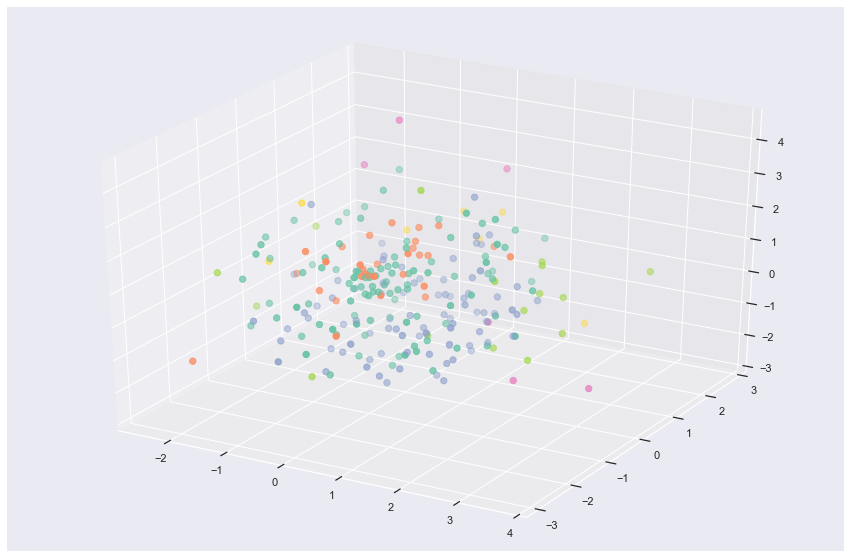

In [371]:
# Multi-dimensional scaling - plot 2d

from mpl_toolkits.mplot3d import Axes3D

cluster_la = AgglomerativeClustering(affinity='precomputed', distance_threshold=None, linkage='complete', n_clusters=6)

la_cluster_labels = cluster_la.fit_predict(LA_X)

# silhoette scores, plot silhoettes
from sklearn import manifold
mds = manifold.MDS(n_components=3, dissimilarity='precomputed', max_iter=100, n_init=1, )
Y = mds.fit_transform(LA_X)
import matplotlib.pyplot as plt
colours = [[102,194,165],
[252,141,98],
[141,160,203],
[231,138,195],
[166,216,84],
[255,217,47]]

fig = plt.figure(figsize=(15,10))
ax = fig.add_subplot(111, projection='3d')
colours = np.array(colours)/255
ax.scatter(Y[:,0], Y[:,1],Y[:,2], c=[ colours[i] for i in la_cluster_labels], s=40)
plt.show()
fig.savefig('./la_cluster_3d_mds.png', dpi=300)

In [66]:
LA_neighborhoods_clustered = neighborhood_simplex.loc[ neighborhood_simplex['City Name'] == 'LA', ['Neighborhood']]
LA_neighborhoods_clustered['clusters'] = -1

LA_neighborhoods_clustered.loc[ ~ LA_neighborhoods_clustered['Neighborhood'].isin(['Universal City','San Marino' ]), ['clusters']]  = np.int32(la_cluster_labels)

LA_neighborhoods_clustered.to_csv('./LA_neighborhoods_clustered.csv',index=False)
LA_neighborhoods_clustered


,Neighborhood,clusters
0,Adams-Normandie,2
1,Agoura Hills,2
3,Alhambra,4
5,Alondra Park,2
6,Altadena,0
...,...,...
428,Willowbrook,2
429,Wilmington,2
430,Windsor Square,3
432,Winnetka,2


In [72]:
# plot LA neighborhoods with folium
import time
import folium



la_lat_lng = (34.15223, -118.24368)


la_map = folium.Map(location=la_lat_lng,zoom_start=9,tiles="Stamen Toner")
colours ='''#66c2a5
#fc8d62
#8da0cb
#e78ac3
#a6d854
#ffd92f'''
colours =colours.strip().split('\n')
# colours = ['orange','purple','green','blue','cyan','black']
print(len(la_json['features']))
dicts = [{'weight' : 1, 'fillColor':c,'fillOpacity' : 0.7} for c in colours]
functs = [lambda x: dicts[i] for i in range(len(colours))]
for i in range(len(la_json['features'])):
    inds = la_json['features'][i]['properties']['name'] == LA_neighborhoods['Neighborhood']
    if sum(inds) == 1:
        index, name, cluster = LA_neighborhoods.loc[inds].values[0]
       
        
        if cluster == -1:
            folium.GeoJson(la_json['features'][i], style_function = lambda x: {'weight' : 1, 'fillColor':'red', 'fillOpacity' : 0.7}).add_to(la_map)
        elif cluster == 0:
            folium.GeoJson(la_json['features'][i], style_function = functs[cluster]).add_to(la_map)
        elif cluster == 1:
            folium.GeoJson(la_json['features'][i], style_function = lambda x: dicts[1]).add_to(la_map)
        elif cluster == 2:
            folium.GeoJson(la_json['features'][i], style_function = lambda x: dicts[2]).add_to(la_map)
        elif cluster == 3:
            folium.GeoJson(la_json['features'][i], style_function = lambda x: dicts[3]).add_to(la_map)
        elif cluster == 4:
            folium.GeoJson(la_json['features'][i], style_function = lambda x: dicts[4]).add_to(la_map)
        elif cluster == 5:
            folium.GeoJson(la_json['features'][i], style_function = lambda x: dicts[5]).add_to(la_map)

time.sleep(5)
la_map.save('la_map_clustered.html')


272


In [ ]:
# plot LA neighborhoods with folium
import time
import folium



la_lat_lng = (34.15223, -118.24368)


la_map = folium.Map(location=la_lat_lng,zoom_start=9,tiles="Stamen Toner")
colours ='''#66c2a5
#fc8d62
#8da0cb
#e78ac3
#a6d854
#ffd92f'''
colours =colours.strip().split('\n')
# colours = ['orange','purple','green','blue','cyan','black']
print(len(la_json['features']))
dicts = [{'weight' : 1, 'fillColor':c,'fillOpacity' : 0.7} for c in colours]
functs = [lambda x: dicts[i] for i in range(len(colours))]
for i in range(len(la_json['features'])):
    inds = la_json['features'][i]['properties']['name'] == LA_neighborhoods['Neighborhood']
    if sum(inds) == 1:
        index, name, cluster = LA_neighborhoods.loc[inds].values[0]
       
        
        if cluster == -1:
            folium.GeoJson(la_json['features'][i], style_function = lambda x: {'weight' : 1, 'fillColor':'red', 'fillOpacity' : 0.7}).add_to(la_map)
        elif cluster == 0:
            folium.GeoJson(la_json['features'][i], style_function = functs[cluster]).add_to(la_map)
        elif cluster == 1:
            folium.GeoJson(la_json['features'][i], style_function = lambda x: dicts[1]).add_to(la_map)
        elif cluster == 2:
            folium.GeoJson(la_json['features'][i], style_function = lambda x: dicts[2]).add_to(la_map)
        elif cluster == 3:
            folium.GeoJson(la_json['features'][i], style_function = lambda x: dicts[3]).add_to(la_map)
        elif cluster == 4:
            folium.GeoJson(la_json['features'][i], style_function = lambda x: dicts[4]).add_to(la_map)
        elif cluster == 5:
            folium.GeoJson(la_json['features'][i], style_function = lambda x: dicts[5]).add_to(la_map)

time.sleep(5)
la_map.save('la_map_clustered.html')


In [73]:
#display LA neighborhood clustered map
from IPython.display import IFrame

print(colours)

IFrame(src='./la_map_clustered.html',width=1000, height=800)

['#66c2a5', '#fc8d62', '#8da0cb', '#e78ac3', '#a6d854', '#ffd92f']



#### 4.2 Training Classifiers on LA Clusters

The results of the classifiers indicated that the support vector machine with radial bias function kernel (SVM) and the Gaussian process with radial bias function kernel (GP) were the best performing classifiers, both in terms of accuracy (71%, 70%) and proficiency (0.47, 0.41). While proficiency was higher for SVM compared to  GP, using an inferential statistical test, there was no credible difference between performance (median difference = 0.02 , 95% HDI = \[-0.10 , 0.14\] includes zero).

Further inspection of the confusion matrix plots for SVM and GP, showed that SVM failed to classify any members of 2 clusters correctly whereas GP did make correct classifications for all of the cluster labels. This provided the rationale for selecting the GP classifer over the SVM.



In [200]:
np.median(post_diff), diff_HDI

(0.017174492767084076, (-0.10184306276127761, 0.1417524989554406))

In [75]:
def calc_entropy(props):
    entropy_est = - sum( [ prop_x * np.log( prop_x) for prop_x in props])
    return entropy_est

def calc_conditional_entropy(prop_cm, prop_known_given_est):
    cond_entropy_est = 0

    for est_ind in range( prop_cm.shape[0]):
        for knw_ind in range( prop_cm.shape[1]):
            cond_entropy_est -=  prop_cm[ est_ind, knw_ind] * np.log( prop_known_given_est[est_ind, knw_ind])
    return cond_entropy_est
    
def calc_proficiency(con_mat):
    total_cm = con_mat.sum()
    prop_known = con_mat.sum(axis=1) / total_cm
    prop_est = con_mat.sum(axis=0) / total_cm
    
    prop_cm = con_mat / total_cm
    
    prop_known_given_est = np.zeros( prop_cm.shape)
    for i in range(len(prop_est)):
        prop_known_given_est[:,i] =  prop_cm[:,i] / prop_est[i]
    #print(prop_est)
    #print(prop_known_given_est)
    entropy_known = calc_entropy(prop_known)

    cond_entropy_known_g_est = calc_conditional_entropy(prop_cm, prop_known_given_est)

    mutual_info = (entropy_known - cond_entropy_known_g_est)

    proficiency = mutual_info / entropy_known

    return proficiency

def calc_accuracy(con_mat):
    total = np.sum(con_mat)
    correct = sum([ con_mat[i,i] for i in range(len(con_mat))])
    return correct/ total


In [76]:
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import confusion_matrix, classification_report

from sklearn.neighbors import KNeighborsClassifier
from sklearn import svm
from sklearn.gaussian_process import GaussianProcessClassifier
from sklearn.gaussian_process.kernels import RBF
from sklearn.tree import DecisionTreeClassifier

performance = {'svc':[],'knn':[], 'tree':[], 'gp':[]}

def cross_val(classifier,name):
    skf = StratifiedKFold(n_splits = 4)
    cms = []
    scores =[]
    for train, test in skf.split(LA_simplex.values, la_cluster_labels):
        #print(LA_simplex.values[train].shape, la_cluster_labels[train].shape)


        clf = classifier.fit(LA_simplex.values[train], la_cluster_labels[train])
        pred_labels = clf.predict(LA_simplex.values[test])
        cms.append(confusion_matrix(pred_labels, la_cluster_labels[test]))
        #print(classification_report(pred_labels, la_cluster_labels[test]))

    cm_ave = None
    for cm in cms:
        if cm_ave is None:
            cm_ave = cm
        else:
            cm_ave += cm
    cm_ave = cm_ave / len(cms)
    new_metric = (name, calc_proficiency(cm_ave +.000001), calc_accuracy(cm_ave))
    print(new_metric)
    scores.append( new_metric)
    return scores, cm_ave
    
print('KNN'.center(80,'.'))

for n_neigh in range(1,11):
    knn = KNeighborsClassifier(n_neighbors=n_neigh, metric=lambda x,y: Multinomial(x).hilbert_distance(Multinomial(y)))

    scores, cm_ave= cross_val(knn, n_neigh)
    performance['knn'].append([scores, cm_ave])

print('SVC'.center(80,'.'))
for kern in ['rbf','linear','poly','sigmoid']:
    svc_kern = svm.SVC(kernel=kern)
    scores, cm_ave = cross_val(svc_kern, kern)
    performance['svc'].append([scores, cm_ave])


print('Tree'.center(80,'.'))
tree_clf = DecisionTreeClassifier(max_depth =5)
scores, cm_ave,  = cross_val(tree_clf, 'tree')
performance['tree'].append([scores, cm_ave])


print('Gaussian Process'.center(80,'.'))
gp_clf = GaussianProcessClassifier(1.0 * RBF(1.0))
scores, cm_ave = cross_val(gp_clf, 'gp')
performance['gp'].append([scores, cm_ave])

......................................KNN.......................................
(1, 0.24236341195306668, 0.6056910569105691)
(2, 0.20527852868250918, 0.556910569105691)
(3, 0.27127719124031235, 0.6300813008130082)
(4, 0.28154923119806474, 0.6219512195121951)
(5, 0.3007096152719962, 0.6341463414634146)
(6, 0.32953330183671364, 0.6422764227642277)
(7, 0.30763917125302653, 0.6341463414634146)
(8, 0.2899486683650503, 0.6097560975609756)
(9, 0.2810244021977327, 0.6138211382113821)
(10, 0.31661910503785534, 0.6422764227642277)
......................................SVC.......................................
('rbf', 0.4773027583036162, 0.7113821138211383)
('linear', 0.03212650167068705, 0.4186991869918699)
('poly', 0.348752830612079, 0.6666666666666666)
('sigmoid', 0.03212650167068705, 0.4186991869918699)
......................................Tree......................................
('tree', 0.23228865596440343, 0.6097560975609756)
................................Gaussian Process...........

   Class      Num    Recall  Precision
0      0  20.0001  0.776685   0.677956
1      1   3.7501  0.499973   0.749930
2      2  16.0001  0.761888   0.711097
3      3   1.2501  0.833067   0.999600
4      4   2.0001  0.499950   0.727150
5      5   0.5001  0.285673   0.999001
   Class      Num    Recall  Precision
0      0  22.5001  0.873770   0.629363
1      1   2.2501  0.299989   0.999778
2      2  17.7501  0.845219   0.797736
3      3   0.0001  0.000067   0.166667
4      4   1.2501  0.312478   0.999600
5      5   0.0001  0.000057   0.166667


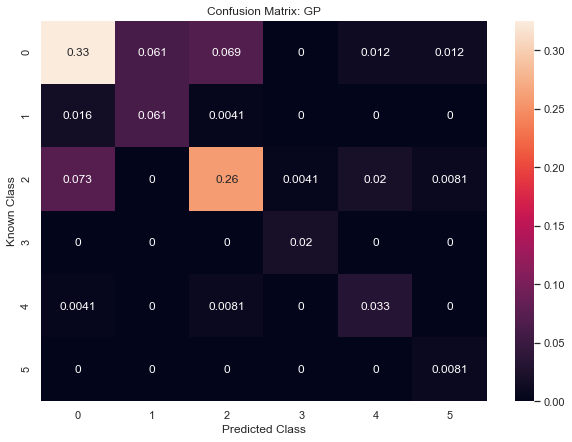

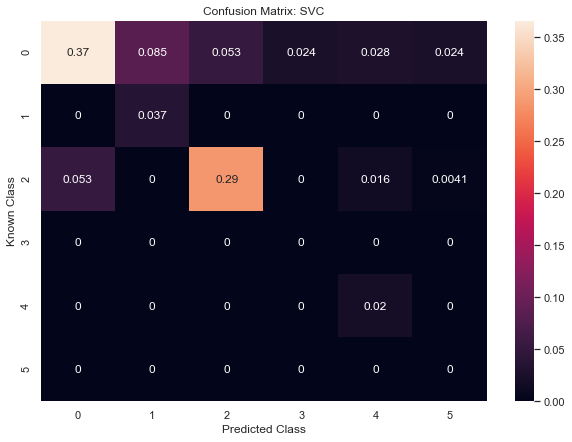

In [377]:
# Best performing classifier was the support vector machine with the radial bias function kernel

def plot_cm(cm, name):
    title='Confusion Matrix: ' + name
    df_cm = pd.DataFrame(cm, index = range(len(cm)),
                  columns = range(len(cm)))
    fig = plt.figure(figsize = (10,7))
    ax = sns.heatmap(df_cm, annot=True)
    ax.set_xlabel('Predicted Class')
    ax.set_ylabel('Known Class')
    ax.set_title(title)
    fig.savefig('./{}.png'.format(title.replace(':','-')), dpi=300)

def show_class_performance(cm):
   
    data_dict = {'Class':[],'Num':[],'Recall':[],'Precision':[]}
    for i in range( len(cm)):
        data_dict['Class'].append(i)
        data_dict['Num'].append(cm[i,i])
        data_dict['Recall'].append(cm[i,i] / sum(cm[:,i]))
        data_dict['Precision'].append(cm[i,i] / sum(cm[i,:]))
    
    df =  df = pd.DataFrame(data_dict)
    return df


        
print(show_class_performance( performance['gp'][0][1]+.0001))
print(show_class_performance( performance['svc'][0][1]+ .0001))
plot_cm(performance['gp'][0][1] / np.sum(performance['gp'][0][1]), 'GP')
plot_cm(performance['svc'][0][1] / np.sum(performance['svc'][0][1]), 'SVC')

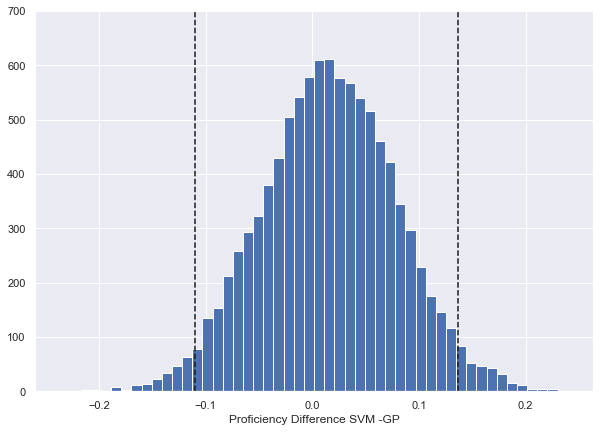

In [376]:
def sample_post_dirichlet(con_mat, n_samples=10000):
    counts = con_mat.ravel()
    prior = np.ones(len(counts))
    alpha = prior + counts
    posterior = [ c.reshape(con_mat.shape) for c in np.random.dirichlet(alpha,size=n_samples)]
    return posterior

def get_HDI(posterior_samples, credible_mass =.95):
    
    sorted_points = sorted(posterior_samples)
    ci_idx_inc = np.ceil(credible_mass * len(sorted_points)).astype('int')
    n_CIs = len(sorted_points) - ci_idx_inc
    ci_width = [0]*n_CIs
    for i in range(0, n_CIs):
        ci_width[i] = sorted_points[i + ci_idx_inc] - sorted_points[i]
    HDI_min = sorted_points[ci_width.index(min(ci_width))]
    HDI_max = sorted_points[ci_width.index(min(ci_width))+ci_idx_inc]
    return(HDI_min, HDI_max)

post_svc_cm = sample_post_dirichlet(performance['svc'][0][1])

post_svc_prof = [calc_proficiency(c) for c in post_svc_cm]
#plt.hist(post_svc_prof,30)

post_gp_cm = sample_post_dirichlet(performance['gp'][0][1])

post_gp_prof = [calc_proficiency(c) for c in post_gp_cm]
post_diff = [x-y for x,y in zip(post_svc_prof,post_gp_prof)]
fig = fig = plt.figure(figsize = (10,7))
diff_counts, diff_vals, _ = plt.hist(post_diff,50)
diff_HDI = get_HDI(post_diff)

plt.vlines(diff_HDI , 0, 700, linestyles = 'dashed')
plt.xlabel('Proficiency Difference SVM -GP')
plt.ylim(0,700)
fig.savefig('./prof_diff_svm-gp.png',dpi=300)


In [210]:
gp_final_clf = GaussianProcessClassifier(1.0 * RBF(1.0))
gp_final_clf.fit(LA_simplex.values, la_cluster_labels)

GaussianProcessClassifier(copy_X_train=True, kernel=1**2 * RBF(length_scale=1),
                          max_iter_predict=100, multi_class='one_vs_rest',
                          n_jobs=None, n_restarts_optimizer=0,
                          optimizer='fmin_l_bfgs_b', random_state=None,
                          warm_start=False)

In [216]:
from joblib import dump, load

dump(gp_final_clf, 'gp_final_clf.joblib') 

['gp_final_clf.joblib']

In [224]:
sum(load('gp_final_clf.joblib').predict(LA_simplex.values) == la_cluster_labels) / len(la_cluster_labels),sum(gp_final_clf.predict(LA_simplex.values) == la_cluster_labels) / len(la_cluster_labels)

(0.9512195121951219, 0.9512195121951219)

#### 4.3 Classifying New York City Neighborhoods

New York Neighborhoods were classified using the Gaussian Process classifier with radial bias function kernel, trained on the Los Angeles Neighborhood Clustering.

The classification results were compared to agglomerative clustering using Hilbert simplex distance with the same number of classes, and displayed using silhouette plots and 2 dimensional embeddings transformed by Multi-Dimensional Scaling.

Both the classification and the clustering grouped the vast majority of neighborhoods together (182 for classification and 183 for clustering). Additionally, while the classifier had six classes, it only labelled New York City neighborhoods with 4 of them.  Taken together, this indicated that in terms of neighborhood venues, New York city is more homogenius than Los Angeles. 

The similarity of performance of the classifier and the clustering indicates that the classifier is performing well.


In [273]:
# process nyc neighborhoods to simplex

NY_simplex = neighborhood_simplex[ neighborhood_simplex['City Name'] == 'NY']

NY_simplex = NY_simplex.drop(columns=['City Name', 'Neighborhood']) 
NY_simplex

,ATM,Accessories Store,Acupuncturist,Adult Boutique,Advertising Agency,Afghan Restaurant,African Restaurant,Airport Gate,Airport Lounge,Airport Service,...,"Indie Theater,Indie Movie Theater,Movie Theater","College Classroom,College Cafeteria","Zoo,Zoo Exhibit","Japanese Restaurant,Japanese Curry Restaurant","Trail,Bike Trail","Theme Park,Theme Park Ride / Attraction","Train Station,Train","Bus Line,Bus Station","Beer Store,Liquor Store","Football Stadium,Soccer Stadium"
2,0.002088,0.002088,0.002088,0.002088,0.002088,0.002088,0.002088,0.002088,0.002088,0.002088,...,0.002088,0.002088,0.002088,0.002088,0.002088,0.002088,0.002088,0.002088,0.002088,0.002088
4,0.002070,0.002070,0.002070,0.002070,0.002070,0.002070,0.002070,0.002070,0.002070,0.002070,...,0.002070,0.002070,0.002070,0.002070,0.002070,0.002070,0.002070,0.008282,0.002070,0.002070
7,0.002160,0.002160,0.002160,0.002160,0.002160,0.002160,0.002160,0.002160,0.002160,0.002160,...,0.002160,0.002160,0.002160,0.002160,0.002160,0.002160,0.002160,0.002160,0.002160,0.002160
9,0.002101,0.002101,0.002101,0.002101,0.002101,0.002101,0.002101,0.002101,0.002101,0.002101,...,0.002101,0.002101,0.002101,0.002101,0.002101,0.002101,0.002101,0.002101,0.004202,0.002101
13,0.001779,0.001779,0.001779,0.001779,0.001779,0.001779,0.001779,0.001779,0.001779,0.001779,...,0.001779,0.001779,0.001779,0.003559,0.001779,0.001779,0.001779,0.001779,0.003559,0.001779
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
438,0.002062,0.002062,0.002062,0.002062,0.002062,0.002062,0.002062,0.002062,0.002062,0.002062,...,0.002062,0.002062,0.002062,0.002062,0.002062,0.002062,0.002062,0.008247,0.004124,0.002062
439,0.002012,0.002012,0.002012,0.002012,0.002012,0.002012,0.002012,0.002012,0.002012,0.002012,...,0.002012,0.002012,0.002012,0.004024,0.002012,0.002012,0.002012,0.002012,0.002012,0.002012
440,0.002004,0.002004,0.002004,0.002004,0.002004,0.002004,0.002004,0.002004,0.002004,0.002004,...,0.002004,0.002004,0.002004,0.002004,0.002004,0.002004,0.002004,0.002004,0.002004,0.002004
441,0.002119,0.002119,0.002119,0.002119,0.002119,0.002119,0.002119,0.002119,0.002119,0.002119,...,0.002119,0.002119,0.002119,0.002119,0.002119,0.002119,0.002119,0.002119,0.002119,0.002119


In [342]:
# predict NY neighborhoods labels
ny_labels = gp_final_clf.predict(NY_simplex.values)
print(pd.Series(ny_labels).value_counts())
neighborhood_simplex['labels'] = -1
neighborhood_simplex.loc[NY_simplex.index, ['labels']] = ny_labels
neighborhood_simplex.loc[LA_simplex.index, ['labels']] = la_cluster_labels


0    182
2      7
4      5
1      1
dtype: int64


In [340]:
# plot NY neighborhoods with folium
import time
import folium

NY_neighborhoods_classified = neighborhood_simplex.loc[ neighborhood_simplex['City Name'] == 'NY', ['Neighborhood']]
NY_neighborhoods_classified.reset_index(inplace=True)
NY_neighborhoods_classified['labels'] = ny_labels
ny_lat_lng = (40.71427, -74.00597)

ny_map = folium.Map(location=ny_lat_lng,zoom_start=11,tiles="Stamen Toner")
colours ='''#66c2a5
#fc8d62
#8da0cb
#e78ac3
#a6d854
#ffd92f'''
colours =colours.strip().split('\n')
# colours = ['orange','purple','green','blue','cyan','black']
print(len(la_json['features']))
dicts = [{'weight' : 1, 'fillColor':c,'fillOpacity' : 0.7} for c in colours]
functs = [lambda x: dicts[i] for i in range(len(colours))]
for i in range(len(ny_json['features'])):

    inds = ny_json['features'][i]['properties']['NTAName'] == NY_neighborhoods_classified['Neighborhood']
    if sum(inds) == 1:
        index, name, label = NY_neighborhoods_classified.loc[inds].values[0]
       
        
        if label == -1:
            folium.GeoJson(ny_json['features'][i], style_function = lambda x: {'weight' : 1, 'fillColor':'red', 'fillOpacity' : 0.7}).add_to(ny_map)
        elif label == 0:
            folium.GeoJson(ny_json['features'][i], style_function = functs[cluster]).add_to(ny_map)
        elif label == 1:
            folium.GeoJson(ny_json['features'][i], style_function = lambda x: dicts[1]).add_to(ny_map)
        elif label == 2:
            folium.GeoJson(ny_json['features'][i], style_function = lambda x: dicts[2]).add_to(ny_map)
        elif label == 3:
            folium.GeoJson(ny_json['features'][i], style_function = lambda x: dicts[3]).add_to(ny_map)
        elif label == 4:
            folium.GeoJson(ny_json['features'][i], style_function = lambda x: dicts[4]).add_to(ny_map)
        elif label == 5:
            folium.GeoJson(ny_json['features'][i], style_function = lambda x: dicts[5]).add_to(ny_map)
    else:
        print(ny_json['features'][i]['properties']['NTAName'])

time.sleep(5)
ny_map.save('ny_map_clustered.html')

272


For n_clusters = 4 The average silhouette_score is : 0.042066317838059045
0    182
2      7
4      5
1      1
dtype: int64
For n_clusters = 4 The average silhouette_score is : 0.1956131125824812
0    183
1      5
2      4
3      3
dtype: int64


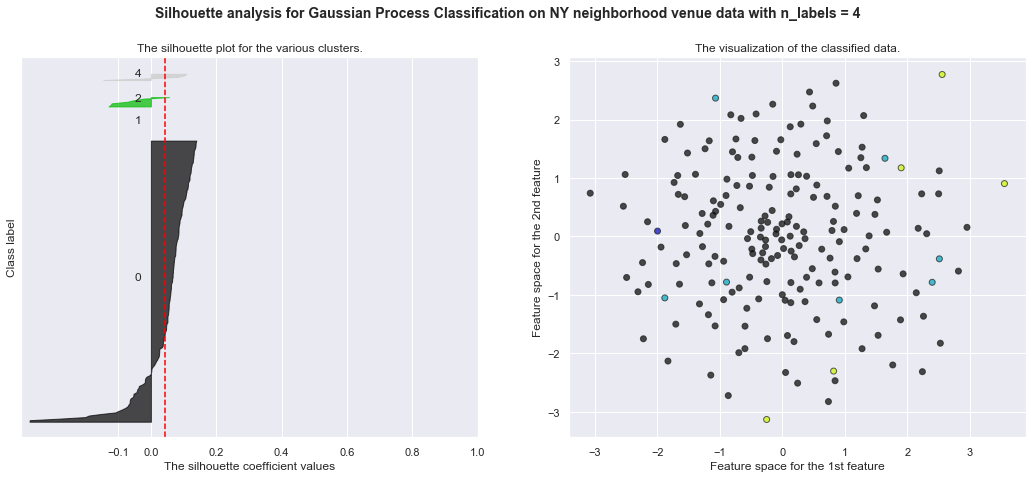

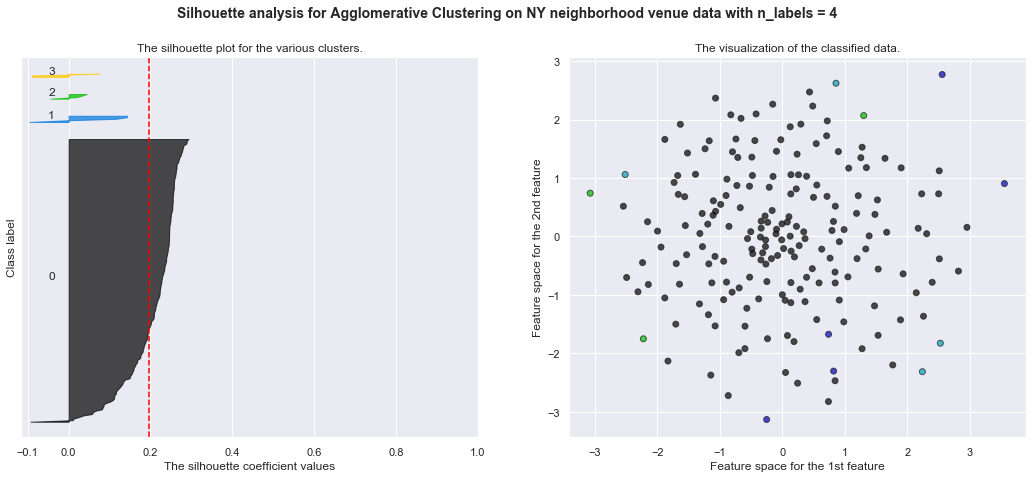

In [379]:
from sklearn.metrics import silhouette_samples, silhouette_score
import matplotlib.cm as cm

NY_X = get_distance_mat(NY_simplex.values)

mds = manifold.MDS(n_components=2, dissimilarity='precomputed', max_iter=100, n_init=1)
Y = mds.fit_transform(NY_X)
n_clusters = 4
clusterer = AgglomerativeClustering(affinity='precomputed', distance_threshold=None, linkage='complete', n_clusters=n_clusters)
ny_cluster_labels = clusterer.fit_predict(NY_X)

for ny_labs, ny_label_process in  [(ny_labels, 'Gaussian Process Classification'), (ny_cluster_labels, 'Agglomerative Clustering')]:
    # Create a subplot with 1 row and 2 columns
    fig, (ax1, ax2) = plt.subplots(1, 2)
    fig.set_size_inches(18, 7)

    # The 1st subplot is the silhouette plot
    # The silhouette coefficient can range from -1, 1

    # The (n_clusters+1)*10 is for inserting blank space between silhouette
    # plots of individual clusters, to demarcate them clearly.
    ax1.set_ylim([0, len(NY_X) + (n_clusters + 1) * 10])
    # The silhouette_score gives the average value for all the samples.
    # This gives a perspective into the density and separation of the formed
    # clusters
    silhouette_avg = silhouette_score(NY_X, ny_labs, metric="precomputed")
    print("For n_clusters =", n_clusters,
          "The average silhouette_score is :", silhouette_avg)

    # Compute the silhouette scores for each sample
    sample_silhouette_values = silhouette_samples(NY_X, ny_labs, metric="precomputed")

    print(pd.Series(ny_labs).value_counts())
    y_lower = 10
    for i in sorted(list(set(ny_labs))):
        # Aggregate the silhouette scores for samples belonging to
        # cluster i, and sort them
        
        ith_cluster_silhouette_values = \
            sample_silhouette_values[ny_labs == i]

        ith_cluster_silhouette_values.sort()

        size_cluster_i = ith_cluster_silhouette_values.shape[0]
        y_upper = y_lower + size_cluster_i

        color = cm.nipy_spectral(float(i) / n_clusters)#colours[i]
        ax1.fill_betweenx(np.arange(y_lower, y_upper),
                          0, ith_cluster_silhouette_values,
                          facecolor=color, edgecolor=color, alpha=0.7)

        # Label the silhouette plots with their cluster numbers at the middle
        ax1.text(-0.05, y_lower + 0.5 * size_cluster_i, str(i))

        # Compute the new y_lower for next plot
        y_lower = y_upper + 10  # 10 for the 0 samples

    ax1.set_title("The silhouette plot for the various clusters.")
    ax1.set_xlabel("The silhouette coefficient values")
    ax1.set_ylabel("Class label")

    # The vertical line for average silhouette score of all the values
    ax1.axvline(x=silhouette_avg, color="red", linestyle="--")

    ax1.set_yticks([])  # Clear the yaxis labels / ticks
    ax1.set_xticks([-0.1, 0, 0.2, 0.4, 0.6, 0.8, 1])

    # 2nd Plot showing the actual clusters formed

    colors = cm.nipy_spectral(ny_labs.astype(float) / 6)


    ax2.scatter(Y[:, 0], Y[:, 1], marker='o', alpha=0.7, c= colors, edgecolor='k' )


    ax2.set_title("The visualization of the classified data.")
    ax2.set_xlabel("Feature space for the 1st feature")
    ax2.set_ylabel("Feature space for the 2nd feature")

    plt.suptitle(("Silhouette analysis for {} on NY neighborhood venue data "
                  "with n_labels = {}".format(ny_label_process, n_clusters)),
                 fontsize=14, fontweight='bold')
    
    fig.savefig('./sil_NY_{}.png'.format(ny_label_process),dpi=300)

plt.show()

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 1, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 3, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0,
       0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 3, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 3, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
      dtype=int64)

In [380]:
#display NY neighborhood classified map
from IPython.display import IFrame

print(colours)

IFrame(src='./ny_map_clustered.html',width=1000, height=800)


[[0.4        0.76078431 0.64705882]
 [0.98823529 0.55294118 0.38431373]
 [0.55294118 0.62745098 0.79607843]
 [0.90588235 0.54117647 0.76470588]
 [0.65098039 0.84705882 0.32941176]
 [1.         0.85098039 0.18431373]]


### 4.4  Exploring the LA Clustering and NY Classified Neighborhoods

By looking at the top 10 venue categories we can get a feel for what the neighborhoods are like. All but cluster 1 are dominated by food establishments. The Clusters were named by their dominant venues:

 - Cluster 0: Pizza Place
 - Cluster 1: Park
 - Cluster 2: Mexican Restaurants
 - Cluster 3: Korean Restaurants
 - Cluster 4: Chinese Restaurants
 - Cluster 5: Food Truck

Comparing these to the classification of New York City Neighborhoods, we see a domination of 182 Pizza Place Neighborhoods, then 7 Mexican Restaurant Neighborhoods, 5 Chinese Restaurant Neighborhood and 1 Park Neighborhood, with no neighborhoods classified in the Korean Restaurant or Food Truck categories.

In [354]:
# Evaluate classification with silhouette scores 

explore_clusters = neighborhood_simplex[ neighborhood_simplex['City Name'] == 'LA'].drop(columns=['Café','Coffee Shop']).groupby('labels').sum()
top_ten_venues = [ ]
for i,row in explore_clusters.iterrows():
    if i == -1:
        continue
    ven_10 = row.sort_values(ascending=False).head(10).index.values
    top_ten_venues.append(ven_10)

df_top = pd.DataFrame(top_ten_venues, columns=[str(k) for k in range(1,11)])


print(pd.Series(ny_labels).value_counts(), pd.Series(la_cluster_labels).value_counts())
#df_top.loc[np.unique(ny_labels)]

df_top


0    182
2      7
4      5
1      1
dtype: int64 0    103
2     84
1     30
4     16
5      7
3      6
dtype: int64


,1,2,3,4,5,6,7,8,9,10
0,Pizza Place,Fast Food Restaurant,Mexican Restaurant,"New American Restaurant,American Restaurant",Sandwich Place,Grocery Store,Sushi Restaurant,Park,Italian Restaurant,Hotel
1,Park,"Trail,Bike Trail",Fast Food Restaurant,Sandwich Place,Mexican Restaurant,Scenic Lookout,Pizza Place,Food Truck,Grocery Store,"Zoo,Zoo Exhibit"
2,Mexican Restaurant,Fast Food Restaurant,Pizza Place,Sandwich Place,Burger Joint,Convenience Store,Pharmacy,Grocery Store,Park,Bakery
3,Korean Restaurant,Pizza Place,Mexican Restaurant,Asian Restaurant,"Japanese Restaurant,Japanese Curry Restaurant",Grocery Store,Burger Joint,Ice Cream Shop,Bakery,"Cantonese Restaurant,Taiwanese Restaurant,Chin..."
4,"Cantonese Restaurant,Taiwanese Restaurant,Chin...",Mexican Restaurant,Pizza Place,"New American Restaurant,American Restaurant",Fast Food Restaurant,"Japanese Restaurant,Japanese Curry Restaurant",Vietnamese Restaurant,Sushi Restaurant,Sandwich Place,Italian Restaurant
5,Food Truck,Mexican Restaurant,"New American Restaurant,American Restaurant",Park,"Restaurant,Bistro",Sandwich Place,Breakfast Spot,Burger Joint,Bakery,Pizza Place


### 5. Discussion

#### 5.1 Summary of Key Results

Los Angeles neighborhoods were clustered into six groups. This grouping was used to train a Gaussian Process Classifier which was used to classify New York City neighborhoods. The resulting classification was compared to Agglomerative Clustering on the New York City neighborhoods and was found to be broadly consistent. New York City neighborhoods were found to be much more homogenius in terms of nearby venues compared to Los Angeles, with the vast majority of neighborhoods labelled by the Pizza Place cluster.

This analysis demonstrated the viability of providing contextual understanding into a new city given knowledge of a current city. As a proof-of-concept case study, this prject has show that there is potential in the idea of simplifying the search for new accommodation in a new city by contextualising real-estate / rental listings based on a users current city.

#### 5.2 Limitations

However, this project is not without limitations. A major issue is the domination of neighborhood venue data by restaurants. It is most likely the case the foursquare data is biased to include these venues, given the popularity of posting about food on social media. So the neighborhood comparison will likely be biased to food-based businesses as well. This is an issue as other non-food venues such as retail, fitness, entertainment and other businesses are important components of a neighborhood.

Another issue is the small amount of data for clustering and training the classifier. As always in data science, more data is better. However, the goal of the current project (contextualise a new city based on current city) limits the data neighborhoods in the current city. 

Finally, only a small subset of potential classifiers were trained and had their performance compared. There could well be better performing classifiers, however, the comparison between clustering and classifying New York City venues indicated that there might not be much room for improvement with the current data.



#### 5.3 Future Directions

There are a number of avenues that could be investigated to expand on the current project. One such avenue would be to look at integrating other types of data for the clustering features, to give a more wholistic comparison of neighborhoods between cities. This could be more information about nearby local and private education facilities, socio-econimic indicators, public transport quality, and demographic details. These factors would most likely have value for people who are considering moving to the new city.

Another avenue for further investigation, would be use a different source for venue data, such as google. Google venue information may be less biased to food-based venues than the foursquare social media data. However, this would add cost as their API is not freely accessible.

AFurther investigation could compare different cities to one another. Although the classification process was validated by comparison to clustering, the value of the insights have not been tested. Local residents from each city could be recruited to assess the veracity of the clustering and classification.




### 6. Conclusion

As a proof of concept, this project aimmed to make an unfamiliar New York understandable to a Los Angeles resident contemplating moving to New York, by relating the neighborhoods between cities. An approach of  Agglomerative clustering using Hilbert-simplex distance for Los Angeles neighborhoods then training a Gaussian Process Classifier and using it to classify New York neighborhoods was used. The approach was demonstrated to be successful with estimated classification accuracy of 70% for 6 classes and comparible results to direct clustering of the New York neighborhoods.

